# Download the Dataset and Imports

In [0]:
!curl --output dataset.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
!unzip dataset.zip
# !rm dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 40.9M  100 40.9M    0     0  50.6M      0 --:--:-- --:--:-- --:--:-- 50.6M
Archive:  dataset.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


In [0]:
import pandas as pd
import html
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.corpus import stopwords 
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import gensim
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Using TensorFlow backend.


#Loading Data and Preprocessing
Tokenization,removing stopwords

In [0]:
# Loading Data

def load_dataset(filename):
    df = pd.read_csv(filename, sep='\t')
    df.drop(df.columns[0], axis=1, inplace=True)
    df.drop(['drugName', 'condition', 'date', 'usefulCount'], axis=1, inplace=True)
    df['review'] = df['review'].apply(lambda x: x[1:-1])
    df['review'] = df['review'].apply(html.unescape)
    df['rating'] = df['rating'].astype('int64')
    df['label'] = df['rating']

    df.label[df['rating'] <= 4] = 0
    df.label[(df['rating'] <= 6) & (df['rating'] >= 5)] = 1
    df.label[df['rating'] >= 7] = 2

    return df

df_train = load_dataset("drugsComTrain_raw.tsv")
df_test = load_dataset("drugsComTest_raw.tsv")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [0]:
stop_words = set(stopwords.words('english'))  
tokenizer = RegexpTokenizer(r'\w+')

In [0]:
def func(row):
    l = tokenizer.tokenize(row['review'])
    s = [i.lower() for i in l if i not in stop_words]
    return s

df_train['processed'] = df_train.apply (lambda row: func(row), axis=1)
df_test['processed'] = df_test.apply (lambda row: func(row), axis=1)


#Embedings

## Glove embeddings

### Download Glove embeddings

In [0]:
!wget "http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip"
!unzip glove.6B.zip
!rm glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


### Util functions

In [0]:
def embed(processed, w2v_dict, default_vec):
    vectors = []
    for w in processed:
        if(w in w2v_dict):
            vectors.append(w2v_dict[w])
        else:
            vectors.append(default_vec)
    vectors = np.array(vectors)
    return vectors

def embed_using_glove(df, embed_dim=50):
    # Load Glove embeddings.
    GLOVE_FILE = 'glove.6B.' + str(embed_dim) + 'd.txt'
    # Get number of vectors and hidden dimensions
    with open(GLOVE_FILE, 'r') as f:
        for i, line in enumerate(f):
            pass
    n_vec = i + 1
    hidden_dim = len(line.split(' ')) - 1
    # Find the average of all embeddings to be assigned to tokens not in the embeddings.
    # Create a word to vector dictionary for embedding.
    avg_vec = np.zeros((hidden_dim), dtype=np.float32)
    w2v_dict = {}
    count = 0
    with open(GLOVE_FILE, 'r') as f:
        for line in f:
            w2v_dict[line.split(' ')[:1][0]] = np.array([float(n) for n in line.split(' ')[1:]], dtype=np.float32)
            avg_vec += np.array([float(n) for n in line.split(' ')[1:]], dtype=np.float32)
            count+=1
    avg_vec/=count

    df['vectors'] = df.apply(lambda row: embed(row['processed'], w2v_dict, avg_vec), axis=1)
    return avg_vec

### Embedding the tokens using Glove
Embeding_D = 50

In [0]:
EMBEDDING_D =50

In [0]:
GLOVE_FILE = 'glove.6B.'+str(EMBEDDING_D)+'d.txt'

# Get number of vectors and hidden dim
with open(GLOVE_FILE, 'r') as f:
    for i, line in enumerate(f):
        pass
n_vec = i + 1
hidden_dim = len(line.split(' ')) - 1


In [0]:
avg_vec = np.zeros((hidden_dim), dtype=np.float32)
w2v_dict = {}
count = 0
with open(GLOVE_FILE, 'r') as f:
    for line in f:
        w2v_dict[line.split(' ')[:1][0]] = np.array([float(n) for n in line.split(' ')[1:]], dtype=np.float32)
        avg_vec += np.array([float(n) for n in line.split(' ')[1:]], dtype=np.float32)
        count+=1
avg_vec/=count
avg_vec

array([-0.12920076, -0.28866628, -0.01224866, -0.05676644, -0.20210965,
       -0.08389011,  0.33359843,  0.16045167,  0.03867431,  0.17833012,
        0.04696583, -0.00285802,  0.29099807,  0.04613704, -0.20923874,
       -0.06613114, -0.06822549,  0.07665912,  0.3134014 ,  0.17848536,
       -0.1225775 , -0.09916984, -0.07495987,  0.06413227,  0.14441176,
        0.60894334,  0.17463093,  0.05335403, -0.01273871,  0.03474107,
       -0.8123879 , -0.04688699,  0.20193407,  0.2031118 , -0.03935686,
        0.06967544, -0.01553638, -0.03405238, -0.06528071,  0.12250231,
        0.13991883, -0.17446303, -0.08011883,  0.0849521 , -0.01041659,
       -0.13705009,  0.20127155,  0.10069408,  0.00653003,  0.01685157],
      dtype=float32)

In [0]:
def foo(row,s,e):
    vectors = []
    for w in row[s:e]:
        if(w in w2v_dict):
            vectors.append(w2v_dict[w])
        else:
            vectors.append(avg_vec)
    vectors = np.array(vectors)
    return vectors

df['vectors'] = df.apply (lambda row: foo(row['processed']), axis=1)
df

,review,rating,label,processed,vectors
0,"It has no side effect, I take it in combinatio...",9,2,"[it, side, effect, i, take, combination, bysto...","[[0.61183, -0.22072, -0.10898, -0.052967, 0.50..."
1,My son is halfway through his fourth week of I...,8,2,"[my, son, halfway, fourth, week, intuniv, we, ...","[[-0.27279, 0.77515, -0.10181, -0.9166, 0.9047..."
2,"I used to take another oral contraceptive, whi...",5,1,"[i, used, take, another, oral, contraceptive, ...","[[0.11891, 0.15255, -0.082073, -0.74144, 0.759..."
3,This is my first time using any form of birth ...,8,2,"[this, first, time, using, form, birth, contro...","[[0.53074, 0.40117, -0.40785, 0.15444, 0.47782..."
4,Suboxone has completely turned my life around....,9,2,"[suboxone, completely, turned, life, around, i...","[[0.48969, -1.058, -0.52617, -0.46258, -0.818,..."
...,...,...,...,...,...
161292,I wrote my first report in Mid-October of 2014...,10,2,"[i, wrote, first, report, mid, october, 2014, ...","[[0.11891, 0.15255, -0.082073, -0.74144, 0.759..."
161293,I was given this in IV before surgey. I immedi...,1,0,"[i, given, iv, surgey, i, immediately, became,...","[[0.11891, 0.15255, -0.082073, -0.74144, 0.759..."
161294,"Limited improvement after 4 months, developed ...",2,0,"[limited, improvement, 4, months, developed, b...","[[-0.061722, -0.074371, -0.15627, 0.43372, -0...."
161295,"I've been on thyroid medication 49 years, I sp...",10,2,"[i, thyroid, medication, 49, years, i, spent, ...","[[0.11891, 0.15255, -0.082073, -0.74144, 0.759..."


## Word2Vec embeddings

### Download the Google word2vec embeddings

In [0]:
!curl --output word2vec.bin.gz https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
!gunzip word2vec.bin.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1570M  100 1570M    0     0  34.5M      0  0:00:45  0:00:45 --:--:-- 35.0M


### Load the word2vec embeddings into memory

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Util funcitons

In [0]:
def embed_w2v(processed, w2v_dict, default_vec):
    vectors = []
    for w in processed:
        if(w in w2v_dict):
            vectors.append(w2v_dict[w])
        else:
            vectors.append(default_vec)
    vectors = np.array(vectors)
    return vectors


### Get equal-class versions of train and test dataset

In [0]:
# df_test_w2v['label'].value_counts()
# df_test_w2v

In [0]:
# df_train_w2v = pd.concat([df_train[df_train['label']==0].sample(n=4829).reset_index(drop=True),df_train[df_train['label']==1].sample(n=4829).reset_index(drop=True),df_train[df_train['label']==2].sample(n=4829).reset_index(drop=True)],ignore_index=True)
# df_test_w2v = pd.concat([df_test[df_test['label']==0].sample(n=4829).reset_index(drop=True),df_test[df_test['label']==1].sample(n=4829).reset_index(drop=True),df_test[df_test['label']==2].sample(n=4829).reset_index(drop=True)],ignore_index=True)

### Convert the tokens into Word2Vec embeddings

In [0]:
# w2v_avg = np.average(w2v_model.vectors, axis=0)
# df_train_w2v['vectors'] = df_train_w2v.apply(lambda row: embed_w2v(row['processed'], w2v_model, w2v_avg), axis=1)
# df_test_w2v['vectors'] = df_test_w2v.apply(lambda row: embed_w2v(row['processed'], w2v_model, w2v_avg), axis=1)

### Save the Embeddings to file

In [0]:
# df_train_w2v.to_pickle("train_w2v.pckl")
# df_test_w2v.to_pickle("test_w2v.pckl")

In [0]:
def embeding_using_w2v(df):
    from gensim.models import KeyedVectors
    w2v_model = KeyedVectors.load_word2vec_format('word2vec.bin', binary=True)
    w2v_avg = np.average(w2v_model.vectors, axis=0)

    df['vectors'] = df.apply(lambda row: embed_w2v(row['processed'], w2v_model, w2v_avg), axis=1)
    df['vectors'] = df.apply(lambda row: embed_w2v(row['processed'], w2v_model, w2v_avg), axis=1)    
    return w2v_avg

## Elmo embeddings

### Install allennlp

In [0]:
!pip install allennlp

### Imports

In [0]:
from allennlp.commands.elmo import ElmoEmbedder
import sys

### Util functions

In [0]:
avg_elmo_embedding = ['1']
def create_elmo_embeddings(elmo, documents, max_sentences = 1000):
    num_sentences = min(max_sentences, len(documents)) if max_sentences > 0 else len(documents)
    print("\n\n:: Lookup of " + str(num_sentences) + " ELMo representations. This takes a while ::")
    embeddings = []
    tokens = documents['processed'].to_numpy()
    
    documentIdx = 0
    for elmo_embedding in elmo.embed_sentences(tokens):  
        document = documents.iloc[documentIdx]
        # Average the 3 layers returned from ELMo
        avg_elmo_embedding = np.average(elmo_embedding, axis=0)             
        embeddings.append(avg_elmo_embedding)        
        
        # Some progress info
        documentIdx += 1
        percent = 100.0 * documentIdx / num_sentences
        line = '[{0}{1}]'.format('=' * int(percent / 2), ' ' * (50 - int(percent / 2)))
        status = '\r{0:3.0f}%{1} {2:3d}/{3:3d} sentences'
        sys.stdout.write(status.format(percent, line, documentIdx, num_sentences))
        
        if max_sentences > 0 and documentIdx >= max_sentences:
            break
            
    return embeddings


### Get smaller versions of train and test dataset

In [0]:
# df_train_elmo = df_train.sample(n=int(df_train.shape[0]/20)).reset_index(drop=True)
# df_test_elmo = df_test.sample(n=int(df_test.shape[0]/20)).reset_index(drop=True)

### Get ELMo embeddings

In [0]:
# elmo = ElmoEmbedder(cuda_device=0) #Set cuda_device to the ID of your GPU if you have one
# df_train_elmo['elmo_embeddings'] = create_elmo_embeddings(elmo, df_train_elmo, -1)
# df_test_elmo['elmo_embeddings'] = create_elmo_embeddings(elmo, df_test_elmo, -1)

In [0]:
def embeding_using_elmo(df):
    elmo = ElmoEmbedder(cuda_device=0) #Set cuda_device to the ID of your GPU if you have one
    df['vectors'] = create_elmo_embeddings(elmo, df, -1)
    return np.full_like(range(1024),0.0)

# GetData

In [0]:
def getleftContext(df,w2v_avg):
    left_context_as_array = df['vectors'].to_numpy()
    app = []
    for i in range(left_context_as_array.shape[0]):
        app.append([w2v_avg,])
    app = np.array(app)
    left_context_as_array = pad_sequences(left_context_as_array, maxlen=sequence_length,dtype='float32')
    print('left context shape')
    print(app.shape)
    print(left_context_as_array.shape)

    left_context_as_array = np.concatenate([app,left_context_as_array],axis = 1)
    print(left_context_as_array.shape)
    left_context_as_array = left_context_as_array[:,:-1,:]

    print('left_context shape',left_context_as_array.shape)
    return left_context_as_array

def getrightContext(df,w2v_avg):
    right_context_as_array = df['vectors'].to_numpy()
    app = []
    for i in range(right_context_as_array.shape[0]):
        app.append([w2v_avg,])
    app = np.array(app)

    right_context_as_array = pad_sequences(right_context_as_array, maxlen=sequence_length,dtype='float32')
    # for el in right_context_as_array:
    #     el = np.vstack([el[1:],[w2v_avg,]])

    right_context_as_array = np.concatenate([right_context_as_array,app],axis = 1)
    print(right_context_as_array.shape)
    right_context_as_array = right_context_as_array[:,1:,:]

    print('right_context shape',right_context_as_array.shape)
    return right_context_as_array

In [0]:
a = np.array([[[1,2],[3,4],[5,6]]])
b = np.array([[[4,5],],])
np.concatenate([b,a],axis=1)

array([[[4, 5],
        [1, 2],
        [3, 4],
        [5, 6]]])

In [0]:
sequence_length = 100
EMBEDDING_D = 300

In [0]:
def getData(normalize = False,k = -1,k_test = 1000,classes=3,embeding='glove'):
    df_train = load_dataset("drugsComTrain_raw.tsv",classes)
    df_test = load_dataset("drugsComTest_raw.tsv",classes)
    
    print(df_train.groupby('label').size())
    print(df_test.groupby('label').size())


    if(normalize):
        mn = df_train.groupby('label').size().min()
        df_train = pd.concat([df_train[df_train['label']==0].sample(n=mn).reset_index(drop=True),df_train[df_train['label']==1].sample(n=mn).reset_index(drop=True),df_train[df_train['label']==2].sample(n=mn).reset_index(drop=True)],ignore_index=True)
        mn = df_test.groupby('label').size().min()
        df_test = pd.concat([df_test[df_test['label']==0].sample(n=mn).reset_index(drop=True),df_test[df_test['label']==1].sample(n=mn).reset_index(drop=True),df_test[df_test['label']==2].sample(n=mn).reset_index(drop=True)],ignore_index=True)

    if(k!=-1):
        df_train = df_train.sample(n=k).reset_index(drop=True)

    if(k_test!=-1):
        df_test = df_test.sample(n=k_test).reset_index(drop=True)

    df_train['processed'] = df_train.apply (lambda row: func(row), axis=1)
    df_test['processed'] = df_test.apply (lambda row: func(row), axis=1)
    
    if(embeding == 'glove'):
        w2v_avg = embed_using_glove(df_train, 50)
        w2v_avg = embed_using_glove(df_test, 50)
        EMBEDDING_D = 50
    if(embeding == 'w2v'):
        w2v_avg = embeding_using_w2v(df_train)
        w2v_avg = embeding_using_w2v(df_test)
        EMBEDDING_D = 300

    if(embeding == 'elmo'):
        w2v_avg = embeding_using_elmo(df_train)
        w2v_avg = embeding_using_elmo(df_test)
        EMBEDDING_D = 1024

    # df_train['vectors'] = df_train.apply (lambda row: foo(row['processed']), axis=1)
    # df_test['vectors'] = df_test.apply (lambda row: foo(row['processed']), axis=1)


    train_data = pad_sequences(df_train['vectors'], maxlen=sequence_length,dtype='float32')
    test_data = pad_sequences(df_test['vectors'], maxlen=sequence_length,dtype='float32')

    l_c = getleftContext(df_train,w2v_avg)
    r_c = getrightContext(df_train,w2v_avg)
    train_data = {'doc': train_data,'l_c':l_c,'r_c':r_c}

    l_c = getleftContext(df_test,w2v_avg)
    r_c = getrightContext(df_test,w2v_avg)
    test_data = {'doc': test_data,'l_c':l_c,'r_c':r_c}

    train_labels = pd.get_dummies(df_train['label']).to_numpy().reshape(-1,classes)
    test_labels = pd.get_dummies(df_test['label']).to_numpy().reshape(-1,classes)


    print(df_train.groupby('label').size())
    print(df_test.groupby('label').size())

    return train_data,test_data,train_labels,test_labels

#Model

In [0]:
from tensorflow import keras 
from keras.layers import Conv1D,Concatenate,Reshape,Dense,Dropout,MaxPool1D,Input,LSTM,concatenate
from keras.models import Model
from keras.layers import Lambda
from keras import backend
import tensorflow as tf
import keras.backend as K
import os
# os.environ['TF_KERAS'] = '1'

In [0]:
def RCNN(embed = 'glove'):
    if(embed == 'glove'):
        EMBEDDING_D = 50
    elif(embed == 'w2v'):
        EMBEDDING_D = 300
    else:
        EMBEDDING_D = 1024
    MAX_TOKENS = 100
    hidden_dim_1 = 200
    hidden_dim_2 = 100
    NUM_CLASSES = 3

    document = Input(shape = (sequence_length,EMBEDDING_D),name='doc')
    left_context = Input(shape = (sequence_length,EMBEDDING_D ),name='l_c')
    right_context = Input(shape = (sequence_length,EMBEDDING_D ),name='r_c')

    # I use LSTM RNNs instead of vanilla RNNs as described in the paper.

    forward = LSTM(hidden_dim_1, return_sequences = True)(left_context)
    backward = LSTM(hidden_dim_1, return_sequences = True, go_backwards = True)(right_context)
    # Keras returns the output sequences in reverse order.

    print(backward.shape)
    # print(type(backward))

    backward = Lambda(lambda x: K.reverse(x,axes=1) )(backward)
    # l = Lambda(lambda x: K.reverse(x,axes=1),output_shape=backward.shape )
    # backward = l(backward)
    print(backward.shape)

    together = concatenate([forward, document, backward], axis = 2) 

    semantic = Conv1D(hidden_dim_2, kernel_size = 1, activation = "tanh")(together) 

    # Keras provides its own max-pooling layers, but they cannot handle variable length input
    # (as far as I can tell). As a result, I define my own max-pooling layer here.
    pool_rnn = Lambda(lambda x: backend.max(x, axis = 1), output_shape = (hidden_dim_2, ))(semantic) 

    output = Dense(NUM_CLASSES, input_dim = hidden_dim_2, activation = "softmax")(pool_rnn) 

    model = Model(inputs = [document, left_context, right_context], outputs = output)
    model.compile(optimizer = "adadelta", loss = "categorical_crossentropy", metrics = ["accuracy"])
    return model

# Training model

##Glove

In [0]:
xTrain,xVal,yTrain,yVal = getData(normalize=True,k=10000)
model = RCNN('glove')

rating
1     21619
2      6931
3      6513
4      5012
5      8013
6      6343
7      9456
8     18890
9     27531
10    50989
dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


rating
1      7299
2      2334
3      2205
4      1659
5      2710
6      2119
7      3091
8      6156
9      9177
10    17016
dtype: int64
label
0     40075
1     14356
2    106866
dtype: int64
label
0    13497
1     4829
2    35440
dtype: int64
(10000, 101, 50)
left_context shape (10000, 100, 50)
(10000, 101, 50)
right_context shape (10000, 100, 50)
(1000, 101, 50)
left_context shape (1000, 100, 50)
(1000, 101, 50)
right_context shape (1000, 100, 50)
label
0    3383
1    3295
2    3322
dtype: int64
label
0    356
1    315
2    329
dtype: int64
(?, ?, 200)
(?, ?, 200)


In [0]:
training = model.fit(x=xTrain, y = yTrain, epochs=15, batch_size=128,validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/15
9000/9000 [==============================] - 25s 3ms/step - loss: 1.0921 - acc: 0.3993 - val_loss: 1.0699 - val_acc: 0.4420
Epoch 2/15
9000/9000 [==============================] - 22s 2ms/step - loss: 1.0148 - acc: 0.4779 - val_loss: 0.9967 - val_acc: 0.5040
Epoch 3/15
9000/9000 [==============================] - 20s 2ms/step - loss: 0.9624 - acc: 0.5343 - val_loss: 0.9780 - val_acc: 0.5210
Epoch 4/15
9000/9000 [==============================] - 21s 2ms/step - loss: 0.9375 - acc: 0.5551 - val_loss: 1.0088 - val_acc: 0.4870
Epoch 5/15
9000/9000 [==============================] - 21s 2ms/step - loss: 0.9072 - acc: 0.5780 - val_loss: 0.9557 - val_acc: 0.5380
Epoch 6/15
9000/9000 [==============================] - 21s 2ms/step - loss: 0.8820 - acc: 0.5936 - val_loss: 0.9594 - val_acc: 0.5190
Epoch 7/15
9000/9000 [==============================] - 21s 2ms/step - loss: 0.8536 - acc: 0.6150 - val_loss: 0.9632 - val_acc: 0.5340
Epoch 8

In [0]:
from sklearn.metrics import classification_report
import numpy as np

Y_test = np.argmax(yVal, axis=1) # Convert one-hot to index
y_pred = model.predict(xVal)
y_pred = y_pred.argmax(axis=-1)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.69      0.62       356
           1       0.50      0.26      0.34       315
           2       0.55      0.67      0.61       329

    accuracy                           0.55      1000
   macro avg       0.54      0.54      0.52      1000
weighted avg       0.54      0.55      0.53      1000



(3.0, 0.0)

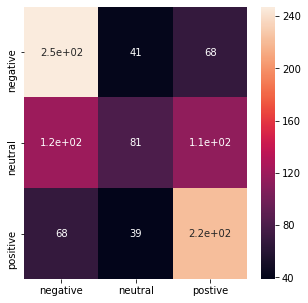

In [0]:
from sklearn import metrics
cm=metrics.confusion_matrix(Y_test,y_pred)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = ['negative','neutral','positive'],
                  columns = ['negative','neutral','postive'])
plt.figure(figsize = (5,5))

ax = sn.heatmap(df_cm, annot=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## Word2Vec

In [0]:
xTrain,xVal,yTrain,yVal = getData(embeding='w2v',normalize=True,k=10000)
model = RCNN('w2v')

rating
1     21619
2      6931
3      6513
4      5012
5      8013
6      6343
7      9456
8     18890
9     27531
10    50989
dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


rating
1      7299
2      2334
3      2205
4      1659
5      2710
6      2119
7      3091
8      6156
9      9177
10    17016
dtype: int64
label
0     40075
1     14356
2    106866
dtype: int64
label
0    13497
1     4829
2    35440
dtype: int64


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(10000, 101, 300)
left_context shape (10000, 100, 300)
(10000, 101, 300)
right_context shape (10000, 100, 300)
(1000, 101, 300)
left_context shape (1000, 100, 300)
(1000, 101, 300)
right_context shape (1000, 100, 300)
label
0    3362
1    3255
2    3383
dtype: int64
label
0    355
1    310
2    335
dtype: int64
(?, ?, 200)
(?, ?, 200)


In [0]:
training = model.fit(x=xTrain, y = yTrain, epochs=15, batch_size=128,validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/15
9000/9000 [==============================] - 27s 3ms/step - loss: 1.0561 - acc: 0.4409 - val_loss: 0.9921 - val_acc: 0.5220
Epoch 2/15
9000/9000 [==============================] - 22s 2ms/step - loss: 0.9629 - acc: 0.5402 - val_loss: 0.9613 - val_acc: 0.5220
Epoch 3/15
9000/9000 [==============================] - 22s 2ms/step - loss: 0.9020 - acc: 0.5848 - val_loss: 0.9195 - val_acc: 0.5620
Epoch 4/15
9000/9000 [==============================] - 23s 3ms/step - loss: 0.8506 - acc: 0.6184 - val_loss: 0.9046 - val_acc: 0.5610
Epoch 5/15
9000/9000 [==============================] - 22s 2ms/step - loss: 0.8125 - acc: 0.6376 - val_loss: 0.8666 - val_acc: 0.6270
Epoch 6/15
9000/9000 [==============================] - 22s 2ms/step - loss: 0.7783 - acc: 0.6614 - val_loss: 0.8473 - val_acc: 0.6190
Epoch 7/15
9000/9000 [==============================] - 23s 3ms/step - loss: 0.7376 - acc: 0.6903 - val_loss: 0.9310 - val_acc: 0.5720
Epoch 8

In [0]:
from sklearn.metrics import classification_report
import numpy as np

Y_test = np.argmax(yVal, axis=1) # Convert one-hot to index
y_pred = model.predict(xVal)
y_pred = y_pred.argmax(axis=-1)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.80      0.70       355
           1       0.57      0.41      0.47       310
           2       0.70      0.67      0.69       335

    accuracy                           0.64      1000
   macro avg       0.63      0.63      0.62      1000
weighted avg       0.63      0.64      0.63      1000



(3.0, 0.0)

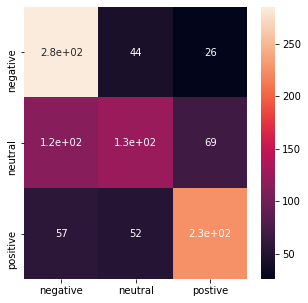

In [0]:
from sklearn import metrics
cm=metrics.confusion_matrix(Y_test,y_pred)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = ['negative','neutral','positive'],
                  columns = ['negative','neutral','postive'])
plt.figure(figsize = (5,5))

ax = sn.heatmap(df_cm, annot=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## Elmo

In [0]:
xTrain,xVal,yTrain,yVal = getData(embeding='elmo',normalize=True,k=5000)
model = RCNN('elmo')

rating
1     21619
2      6931
3      6513
4      5012
5      8013
6      6343
7      9456
8     18890
9     27531
10    50989
dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


rating
1      7299
2      2334
3      2205
4      1659
5      2710
6      2119
7      3091
8      6156
9      9177
10    17016
dtype: int64
label
0     40075
1     14356
2    106866
dtype: int64
label
0    13497
1     4829
2    35440
dtype: int64


:: Lookup of 5000 ELMo representations. This takes a while ::
100%[==================================================] 5000/5000 sentences

:: Lookup of 1000 ELMo representations. This takes a while ::
100%[==================================================] 1000/1000 sentencesleft context shape
(5000, 1, 1024)
(5000, 100, 1024)
(5000, 101, 1024)
left_context shape (5000, 100, 1024)
(5000, 101, 1024)
right_context shape (5000, 100, 1024)
left context shape
(1000, 1, 1024)
(1000, 100, 1024)
(1000, 101, 1024)
left_context shape (1000, 100, 1024)
(1000, 101, 1024)
right_context shape (1000, 100, 1024)
label
0    1656
1    1679
2    1665
dtype: int64
label
0    355
1    327
2    318
dtype: int64



(?, ?, 200)
(?, ?, 200)




In [0]:
training = model.fit(x=xTrain, y = yTrain, epochs=15, batch_size=128,validation_split=0.1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4500 samples, validate on 500 samples
Epoch 1/15





4500/4500 [==============================] - 23s 5ms/step - loss: 1.1234 - acc: 0.3936 - val_loss: 1.1376 - val_acc: 0.3720
Epoch 2/15
4500/4500 [==============================] - 16s 4ms/step - loss: 1.0010 - acc: 0.4956 - val_loss: 1.0534 - val_acc: 0.4520
Epoch 3/15
4500/4500 [==============================] - 16s 4ms/step - loss: 0.9361 - acc: 0.5498 - val_loss: 0.9290 - val_acc: 0.5760
Epoch 4/15
4500/4500 [==============================] - 16s 4ms/step - loss: 0.8534 - acc: 0.6098 - val_loss: 0.9052 - val_acc: 0.5540
Epoch 5/15
4500/4500 [==============================] - 16s 4ms/step - loss: 0.8008 - acc: 0.6513 - val_loss: 1.1508 - val_acc: 0.4760
Epoch 6/15
4500/4500 [==============================] - 16s 4ms/step - loss: 0.7427 - acc: 0.6878 - val_loss: 0.9624 - val_acc: 0.5360
Epoch 7/15
4500/4500 [===================

In [0]:
from sklearn.metrics import classification_report
import numpy as np

Y_test = np.argmax(yVal, axis=1) # Convert one-hot to index
y_pred = model.predict(xVal)
y_pred = y_pred.argmax(axis=-1)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.53      0.62       355
           1       0.56      0.43      0.49       327
           2       0.52      0.81      0.63       318

    accuracy                           0.58      1000
   macro avg       0.61      0.59      0.58      1000
weighted avg       0.61      0.58      0.58      1000



(3.0, 0.0)

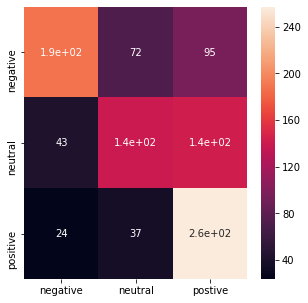

In [0]:
from sklearn import metrics
cm=metrics.confusion_matrix(Y_test,y_pred)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = ['negative','neutral','positive'],
                  columns = ['negative','neutral','postive'])
plt.figure(figsize = (5,5))

ax = sn.heatmap(df_cm, annot=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)